In [1]:
import os
import pandas as pd
import datetime
from datetime import date
import time
import numpy as np

## Download [this query on Quarry](https://quarry.wmcloud.org/query/59058) of 50k random users (with userpages who registered before 2020-10)

In [2]:
!wget https://quarry.wmcloud.org/run/585296/output/0/tsv -O user_reg_with_userpages.tsv

--2021-10-05 21:58:50--  https://quarry.wmcloud.org/run/585296/output/0/tsv
Resolving quarry.wmcloud.org (quarry.wmcloud.org)... 172.16.0.164
Connecting to quarry.wmcloud.org (quarry.wmcloud.org)|172.16.0.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/tab-separated-values]
Saving to: ‘user_reg_with_userpages.tsv’

user_reg_with_userp     [  <=>               ]   1.71M  4.47MB/s    in 0.4s    

2021-10-05 21:58:51 (4.47 MB/s) - ‘user_reg_with_userpages.tsv’ saved [1795476]



In [3]:
!wc -l user_reg_with_userpages.tsv

50001 user_reg_with_userpages.tsv


In [4]:
!head user_reg_with_userpages.tsv

In [5]:
editors_df = pd.read_csv('user_reg_with_userpages.tsv', delimiter='\t', infer_datetime_format=True)
editors_df

,user_name,user_id,user_registration
0,KingRiach,27773404,20160307220704
1,Ctambo,6492102,20080221002533
2,Awisely,13820329,20110118230413
3,Shankhamita,16009368,20120101171414
4,Abhinayaprithivi,28005397,20160404204752
...,...,...,...
49995,Bandgeek1732,16336675,20120221035543
49996,Werqty12376,18321203,20130125002347
49997,Chrisboote,482416,20051007102059
49998,Mariibog,24622706,20150402172429


### Function for calculating future dates

In [6]:
def add_days(d, days):
    """Return a date that's `years` years after the date (or datetime)
    object `d`. Return the same calendar date (month and day) in the
    destination year, if it exists, otherwise use the following day
    (thus changing February 29 to March 1).
    """
    return d + datetime.timedelta(days=days)


In [7]:
add_days(datetime.datetime(2010,1,1),365)

datetime.datetime(2011, 1, 1, 0, 0)

In [8]:
add_days(datetime.datetime(2010,1,1),364)

datetime.datetime(2010, 12, 31, 0, 0)

## Building one SQL query for each user's edits

In [9]:
query_list = []
for index, row in editors_df.iterrows():
    user_registration = row['user_registration']
    reg_dt = datetime.datetime.strptime(str(user_registration), "%Y%m%d%H%M%S")

    start_date = add_days(reg_dt, 182)
    end_date = add_days(reg_dt, 365)
    reg_year_mo = reg_dt.strftime("%Y-%m")
    

    query = "select " + str(row['user_id']) + " as user_id, " + str(row['user_registration']) + " as user_registration,"
    query += "'" + str(reg_year_mo) + "' as year_mo, "
    query += """count(rev_id) as survival_1yr from ( select rev_id from revision_userindex where rev_actor = """ + str(row['user_id'])
    query += " and rev_timestamp BETWEEN " + start_date.strftime("%Y%m%d%H%M%S") 
    query += " and " + end_date.strftime("%Y%m%d%H%M%S") + " limit 1 ) as s"

    query_list.append(query)

In [10]:
query_list[0:5]

["select 27773404 as user_id, 20160307220704 as user_registration,'2016-03' as year_mo, count(rev_id) as survival_1yr from ( select rev_id from revision_userindex where rev_actor = 27773404 and rev_timestamp BETWEEN 20160905220704 and 20170307220704 limit 1 ) as s",
 "select 6492102 as user_id, 20080221002533 as user_registration,'2008-02' as year_mo, count(rev_id) as survival_1yr from ( select rev_id from revision_userindex where rev_actor = 6492102 and rev_timestamp BETWEEN 20080821002533 and 20090220002533 limit 1 ) as s",
 "select 13820329 as user_id, 20110118230413 as user_registration,'2011-01' as year_mo, count(rev_id) as survival_1yr from ( select rev_id from revision_userindex where rev_actor = 13820329 and rev_timestamp BETWEEN 20110719230413 and 20120118230413 limit 1 ) as s",
 "select 16009368 as user_id, 20120101171414 as user_registration,'2012-01' as year_mo, count(rev_id) as survival_1yr from ( select rev_id from revision_userindex where rev_actor = 16009368 and rev_tim

## Querying the database with a manually-written query

In [11]:
import pymysql

# Host urls are like {wiki}.{analytics,web}.db.svc.wikimedia.cloud
host = "enwiki.web.db.svc.wikimedia.cloud"
credentials = ".my.cnf"

query = """SELECT
            13065449 as user_id,
            20100913082123 as user_registration,
            '2010-09' as year_mo,
            count(rev_id) as survival_1yr
            
            FROM (
                    SELECT rev_id 
                    FROM revision_userindex
                    WHERE rev_actor = 13065449
                        AND rev_timestamp BETWEEN 20110913082123 and 20120913082123
                        LIMIT 1 
                  ) as s;"""

#query = "show tables"

#query = "describe revision_userindex"

#query = "select * from user limit 1"

conn = pymysql.connect(
    host=host,
    read_default_file=credentials,
    database="enwiki_p"
)

with conn.cursor() as cur:
        cur.execute(query)
        data = cur.fetchall()
        print(data)
        
conn.close()




((13065449, 20100913082123, '2010-09', 0),)


## Test to query 5 editors from the live SQL database

In [12]:
conn = pymysql.connect(
    host=host,
    read_default_file=credentials,
    database="enwiki_p"
)

data_list = []

for e_query in query_list[0:5]:
    with conn.cursor() as cur:
        cur.execute(e_query)
        data = cur.fetchall()
        for row in data:
            print("Registration date", row[2])
            print("1 year survival", row[3])
            #print(str(row[0], encoding='utf-8'))
            result = {}
            result['reg_date'] = row[2]
            result['survival'] = row[3]
            
            data_list.append(result)
conn.close()

Registration date 2016-03
1 year survival 0
Registration date 2008-02
1 year survival 0
Registration date 2011-01
1 year survival 0
Registration date 2012-01
1 year survival 0
Registration date 2016-04
1 year survival 0


In [13]:
pd.DataFrame(data_list)

,reg_date,survival
0,2016-03,0
1,2008-02,0
2,2011-01,0
3,2012-01,0
4,2016-04,0


### Query all 50,000 editor histories

In [14]:
conn = pymysql.connect(
    host=host,
    read_default_file=credentials,
    database="enwiki_p"
)

data_list = []

for e_query in query_list:
    with conn.cursor() as cur:
        cur.execute(e_query)
        data = cur.fetchall()
        for row in data:
            #print("Registration date", row[2])
            #print("1 year survival", row[3])
            #print(str(row[0], encoding='utf-8'))
            result = {}
            result['reg_date'] = row[2]
            result['survival'] = row[3]
            
            data_list.append(result)
            
            if(len(data_list) % 1000 == 0):
                print(len(data_list))
            
conn.close()

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


In [15]:
retention_df = pd.DataFrame(data_list)
len(retention_df)
retention_df

,reg_date,survival
0,2016-03,0
1,2008-02,0
2,2011-01,0
3,2012-01,0
4,2016-04,0
...,...,...
49995,2012-02,0
49996,2013-01,0
49997,2005-10,0
49998,2015-04,0


### Plot results

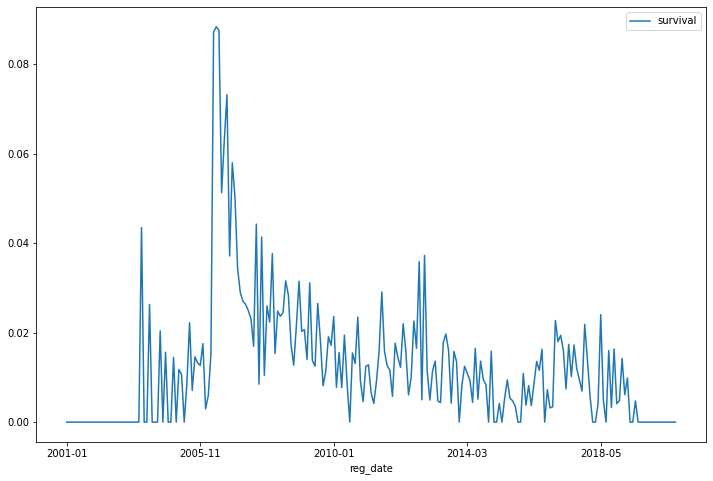

In [16]:
retention_group = retention_df.groupby(["reg_date"])
monthly_averages = retention_group.aggregate({"survival":np.mean})
#monthly_averages = monthly_averages.query("reg_date >= '2006-01'")
fig = monthly_averages.plot(figsize=(12,8))


## Assignment 2

This does not check to see if the editor actually made an edit to an article, only that they registered. Expand to filter out every user who did not make an edit in their first six months. You will need to either keep the first query to the revision table for every user and add a second query for every user to filter out those who did not make an edit, or you can try to modify the first query to revision table in the database to do return a result that will let you measure survival and do the filtering. Remember that you must join with the page table to filter by namespaces (articles are namespace 0). Here is an example query for getting a user's edits: https://quarry.wmcloud.org/query/59069
